Application Record shape: (438557, 18)
Credit Record shape: (1048575, 3)
Merged shape: (25134, 19)


<ipython-input-3-8fc548bc89c6>:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged[col].fillna(df_merged[col].median(), inplace=True)


X_train shape: (20107, 17) X_test shape: (5027, 17)

Class distribution in y_train:
1    17295
0     2812
Name: count, dtype: int64

After SMOTE, new class distribution in y_train_res:
1    17295
0    17295
Name: count, dtype: int64

=== Baseline RF (SMOTE) Performance ===
Confusion Matrix:
[[ 348  355]
 [1952 2372]]

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.50      0.23       703
           1       0.87      0.55      0.67      4324

    accuracy                           0.54      5027
   macro avg       0.51      0.52      0.45      5027
weighted avg       0.77      0.54      0.61      5027



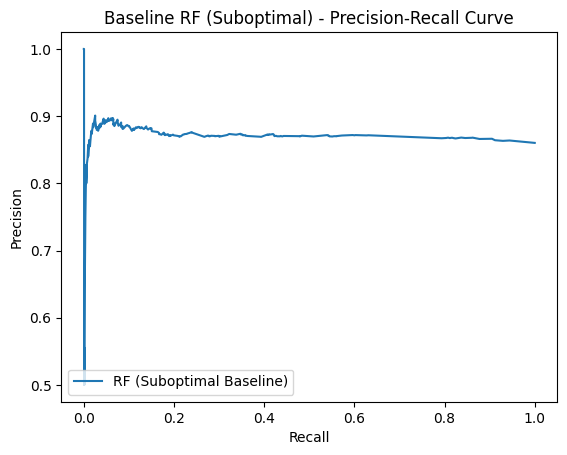

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters from RandomizedSearchCV (Optimizing for AUC): {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None}

=== Tuned RF (SMOTE, Optimized for AUC) Performance ===
Confusion Matrix:
[[ 301  402]
 [ 400 3924]]

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.43      0.43       703
           1       0.91      0.91      0.91      4324

    accuracy                           0.84      5027
   macro avg       0.67      0.67      0.67      5027
weighted avg       0.84      0.84      0.84      5027



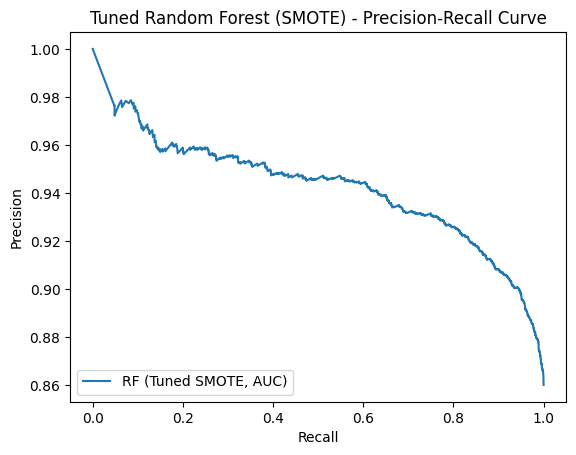

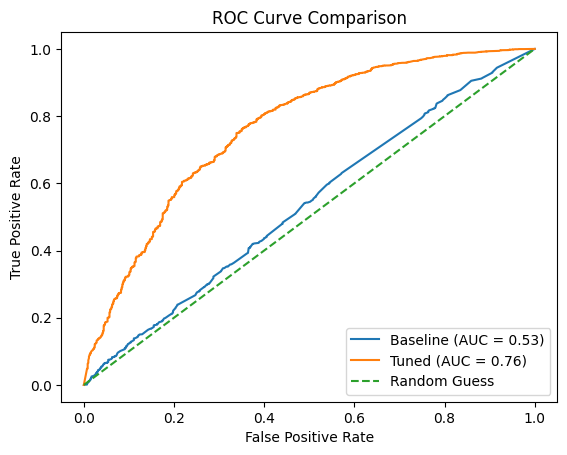


Comparison of Baseline vs. Tuned Model:
Baseline AUC: 0.535
Tuned AUC:    0.764


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, precision_recall_curve)
from imblearn.over_sampling import SMOTE

# ------------------------------
# 1. Load the Files
# ------------------------------
df_app = pd.read_csv("/content/application_record.csv")
df_cr = pd.read_csv("/content/credit_record.csv")

print("Application Record shape:", df_app.shape)
print("Credit Record shape:", df_cr.shape)

# Drop rows with missing values (adjust or impute as needed)
df_app.dropna(inplace=True)
df_cr.dropna(inplace=True)

# ------------------------------
# 2. Derive TARGET from Credit Record
# ------------------------------
# Convert STATUS to numeric and compute maximum status per ID.
df_cr['STATUS'] = pd.to_numeric(df_cr['STATUS'], errors='coerce')
df_status = df_cr.groupby('ID')['STATUS'].max().reset_index()
df_status.rename(columns={'STATUS': 'MAX_STATUS'}, inplace=True)

# If MAX_STATUS is >= 2, mark as "bad" (TARGET=0); otherwise "good" (TARGET=1)
df_status['TARGET'] = df_status['MAX_STATUS'].apply(lambda x: 1 if x < 2 else 0)

# Merge with application data (inner join keeps only IDs with credit records)
df_merged = pd.merge(df_app, df_status[['ID', 'TARGET']], on='ID', how='inner')
print("Merged shape:", df_merged.shape)

# ------------------------------
# 3. Basic Feature Encoding & Scaling
# ------------------------------
# List of categorical columns for label encoding
categorical_cols = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'
]
for col in categorical_cols:
    if col in df_merged.columns:
        le = LabelEncoder()
        df_merged[col] = le.fit_transform(df_merged[col].astype(str))

# For numeric columns, fill missing values with median and apply scaling.
numeric_cols = [
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH',
    'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS'
]
for col in numeric_cols:
    if col in df_merged.columns:
        df_merged[col].fillna(df_merged[col].median(), inplace=True)

scaler = StandardScaler()
for col in numeric_cols:
    if col in df_merged.columns:
        df_merged[col] = scaler.fit_transform(df_merged[[col]])

# ------------------------------
# 4. Train/Test Split
# ------------------------------
features_to_drop = ['ID', 'TARGET']
X = df_merged.drop(columns=features_to_drop)
y = df_merged['TARGET'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("\nClass distribution in y_train:")
print(pd.Series(y_train).value_counts())

# ------------------------------
# 5. Handling Imbalance with SMOTE
# ------------------------------
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("\nAfter SMOTE, new class distribution in y_train_res:")
print(pd.Series(y_train_res).value_counts())

# ------------------------------
# 6. Baseline Random Forest (Intentionally Suboptimal) on SMOTE Data
# ------------------------------
# We purposely use low n_estimators and shallow depth to degrade performance.
baseline_rf_smote = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=42)
baseline_rf_smote.fit(X_train_res, y_train_res)

y_pred_smote = baseline_rf_smote.predict(X_test)
y_pred_smote_proba = baseline_rf_smote.predict_proba(X_test)[:, 1]

print("\n=== Baseline RF (SMOTE) Performance ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_smote))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote))

# Plot Precision-Recall Curve for Baseline
prec_smote, rec_smote, _ = precision_recall_curve(y_test, y_pred_smote_proba)
plt.figure()
plt.plot(rec_smote, prec_smote, label="RF (Suboptimal Baseline)")
plt.title("Baseline RF (Suboptimal) - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

# ------------------------------
# 7. Hyperparameter Tuning with RandomizedSearchCV
# ------------------------------
# Define a broader parameter distribution for a better model.
param_distributions = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_distributions,
    scoring='roc_auc',   # Optimize for AUC
    cv=3,                # 3-fold cross-validation
    n_iter=20,           # Try 20 random combinations for a more thorough search
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit hyperparameter tuning on SMOTE-resampled training data
random_search.fit(X_train_res, y_train_res)

# Retrieve the best model from tuning
best_model_smote = random_search.best_estimator_
print("\nBest parameters from RandomizedSearchCV (Optimizing for AUC):", random_search.best_params_)

# Evaluate the tuned model on the test set
y_pred_tuned_smote = best_model_smote.predict(X_test)
y_pred_tuned_smote_proba = best_model_smote.predict_proba(X_test)[:, 1]

print("\n=== Tuned RF (SMOTE, Optimized for AUC) Performance ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned_smote))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned_smote))

# Plot Precision-Recall Curve for the tuned model
prec_tuned_smote, rec_tuned_smote, _ = precision_recall_curve(y_test, y_pred_tuned_smote_proba)
plt.figure()
plt.plot(rec_tuned_smote, prec_tuned_smote, label="RF (Tuned SMOTE, AUC)")
plt.title("Tuned Random Forest (SMOTE) - Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

# ------------------------------
# 8. Compare ROC Curves for Baseline and Tuned Models
# ------------------------------
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_smote_proba)
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_tuned_smote_proba)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

plt.figure()
plt.plot(fpr_baseline, tpr_baseline, label=f"Baseline (AUC = {roc_auc_baseline:.2f})")
plt.plot(fpr_tuned, tpr_tuned, label=f"Tuned (AUC = {roc_auc_tuned:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Guess")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

print("\nComparison of Baseline vs. Tuned Model:")
print(f"Baseline AUC: {roc_auc_baseline:.3f}")
print(f"Tuned AUC:    {roc_auc_tuned:.3f}")
